In [2]:
from sklearn.ensemble import RandomForestRegressor
from data_preparation import Preparation
import pandas as pd
from mlforecast import MLForecast
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_percentage_error
from missing_timestamps import remove_duplicates
from sklearn.ensemble import RandomForestRegressor
from mlforecast.target_transforms import Differences
from numba import njit
from window_ops.expanding import expanding_mean
from window_ops.rolling import rolling_mean
import lightgbm as lgb
import xgboost as xgb
from statistics import stdev, mean
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import numpy as np





/home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [5]:
data = Preparation(r'/home/iva/Desktop/operato-meteo-1/data/MAS_processed/ELES-MAS-5001.csv.gz', "AMBIENT_TEMPERATURE")
train, test = data.split()
train_processed = remove_duplicates(train)
#train_processed_ = train_processed["AMBIENT_TEMPERATURE"].copy().squeeze()
train_processed_ = train_processed.asfreq("5T")#.fillna(method="ffill")
test_processed = remove_duplicates(test)
test_processed_ = test_processed.asfreq("5T").fillna(method="ffill")
#test_processed_ = test_processed["AMBIENT_TEMPERATURE"].copy().squeeze()

In [3]:
train_processed

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 10:25:00,7.5
2020-10-13 10:30:00,7.4
2020-10-13 10:35:00,7.5
2020-10-13 10:40:00,7.6
...,...
2022-12-31 23:35:00,0.8
2022-12-31 23:40:00,1.0
2022-12-31 23:45:00,0.8


In [3]:
int_indices = [t for t in range(1, len(train_processed)+1)]

In [31]:
dataset_train = pd.DataFrame()
dataset_train["ds"] = train_processed_.index
dataset_train["y"] = train_processed_["AMBIENT_TEMPERATURE"].values
dataset_train["unique_id"] = "AMBIENT_TEMPERATURE"
dataset_train

,ds,y,unique_id
0,2020-10-13 10:20:00,7.4,AMBIENT_TEMPERATURE
1,2020-10-13 10:25:00,7.5,AMBIENT_TEMPERATURE
2,2020-10-13 10:30:00,7.4,AMBIENT_TEMPERATURE
3,2020-10-13 10:35:00,7.5,AMBIENT_TEMPERATURE
4,2020-10-13 10:40:00,7.6,AMBIENT_TEMPERATURE
...,...,...,...
233151,2022-12-31 23:35:00,0.8,AMBIENT_TEMPERATURE
233152,2022-12-31 23:40:00,1.0,AMBIENT_TEMPERATURE
233153,2022-12-31 23:45:00,0.8,AMBIENT_TEMPERATURE
233154,2022-12-31 23:50:00,0.6,AMBIENT_TEMPERATURE


In [32]:
dataset_train[dataset_train["ds"] == '2020-10-13 10:55:00']

,ds,y,unique_id
7,2020-10-13 10:55:00,NaN,AMBIENT_TEMPERATURE


In [33]:
models = [RandomForestRegressor(random_state=123)]
model = MLForecast(models=models,
                   freq="5T",
                    lags=[1],
                    date_features=['minute', 'hour', 'dayofweek', 'day', 'dayofyear'],
                    num_threads=6)
model.fit(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
#prepared_df = model.preprocess(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
#X_train, y_train = prepared_df.drop(columns=['unique_id', 'ds', 'y']), prepared_df['y']

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:7                                                                                    │
│                                                                                                  │
│    4 │   │   │   │   │   lags=[1],                                                               │
│    5 │   │   │   │   │   date_features=['minute', 'hour', 'dayofweek', 'day', 'dayofyear'],      │
│    6 │   │   │   │   │   num_threads=6)                                                          │
│ ❱  7 model.fit(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_featu    │
│    8 #prepared_df = model.preprocess(dataset_train, id_col='unique_id', time_col='ds', target    │
│    9 #X_train, y_train = prepared_df.drop(columns=['unique_id', 'ds', 'y']), prepared_df['y']    │
│   10                                                                                             │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/mlforecast/forecast.py:377 in    │
│ fit                                                                                              │
│                                                                                                  │
│   374 │   │   │   │   n_windows=prediction_intervals.n_windows,                                  │
│   375 │   │   │   │   window_size=prediction_intervals.window_size,                              │
│   376 │   │   │   )                                                                              │
│ ❱ 377 │   │   X, y = self.preprocess(                                                            │
│   378 │   │   │   data,                                                                          │
│   379 │   │   │   id_col=id_col,                                                                 │
│   380 │   │   │   time_col=time_col,                                                             │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/mlforecast/forecast.py:236 in    │
│ preprocess                                                                                       │
│                                                                                                  │
│   233 │   │   result : pandas DataFrame or tuple of pandas Dataframe and either a pandas Serie   │
│   234 │   │   │   `data` plus added features and target(s).                                      │
│   235 │   │   """                                                                                │
│ ❱ 236 │   │   return self.ts.fit_transform(                                                      │
│   237 │   │   │   data,                                                                          │
│   238 │   │   │   id_col=id_col,                                                                 │
│   239 │   │   │   time_col=time_col,                                                             │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/mlforecast/core.py:400 in        │
│ fit_transform                                                                                    │
│                                                                                                  │
│   397 │   │   """                                                                                │
│   398 │   │   self.dropna = dropna                                                               │
│   399 │   │   self.keep_last_n = keep_last_n                                                     │
│ ❱ 400 │   │   self._fit(data, id_col, time_col, target_col,

In [11]:
test_processed_.iloc[0]

AMBIENT_TEMPERATURE    0.0
Name: 2023-01-01 00:20:00, dtype: float64

In [16]:
dataset_test = pd.DataFrame()
dataset_test["ds"] = test_processed_.index
dataset_test["y"] = test_processed_["AMBIENT_TEMPERATURE"].values
dataset_test["unique_id"] = "AMBIENT_TEMPERATURE"
dataset_test

,ds,y,unique_id
0,2023-01-01 00:20:00,0.0,AMBIENT_TEMPERATURE
1,2023-01-01 00:25:00,0.0,AMBIENT_TEMPERATURE
2,2023-01-01 00:30:00,-0.0,AMBIENT_TEMPERATURE
3,2023-01-01 00:35:00,0.0,AMBIENT_TEMPERATURE
4,2023-01-01 00:40:00,0.1,AMBIENT_TEMPERATURE
...,...,...,...
43455,2023-05-31 21:35:00,14.0,AMBIENT_TEMPERATURE
43456,2023-05-31 21:40:00,13.9,AMBIENT_TEMPERATURE
43457,2023-05-31 21:45:00,13.9,AMBIENT_TEMPERATURE
43458,2023-05-31 21:50:00,13.9,AMBIENT_TEMPERATURE


In [18]:
dataset_test.iloc[0:2]

,ds,y,unique_id
0,2023-01-01 00:20:00,0.0,AMBIENT_TEMPERATURE
1,2023-01-01 00:25:00,0.0,AMBIENT_TEMPERATURE


In [21]:
dataset_test.iloc[0]

ds           2023-01-01 00:20:00
y                            0.0
unique_id    AMBIENT_TEMPERATURE
Name: 0, dtype: object

In [27]:
just_test = model.predict(1, new_data=dataset_test.iloc[0:3])
just_test

,unique_id,ds,RandomForestRegressor
0,AMBIENT_TEMPERATURE,2023-01-01 00:35:00,0.038


In [14]:
model.fit(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 model.fit(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_featu     │
│   2                                                                                              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/mlforecast/forecast.py:389 in    │
│ fit                                                                                              │
│                                                                                                  │
│   386 │   │   │   return_X_y=True,                                                               │
│   387 │   │   )                                                                                  │
│   388 │   │   X = X[self.ts.features_order_]                                                     │
│ ❱ 389 │   │   return self.fit_models(X, y)                                                       │
│   390 │                                                                                          │
│   391 │   def predict(                                                                           │
│   392 │   │   self,                                                                              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/mlforecast/forecast.py:277 in    │
│ fit_models                                                                                       │
│                                                                                                  │
│   274 │   │   │   │   │   │   clone(model).fit(X.loc[keep], y.loc[keep, col])                    │
│   275 │   │   │   │   │   )                                                                      │
│   276 │   │   │   else:                                                                          │
│ ❱ 277 │   │   │   │   self.models_[name] = clone(model).fit(X, y)                                │
│   278 │   │   return self                                                                        │
│   279 │                                                                                          │
│   280 │   def _conformity_scores(                                                                │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/sklearn/ensemble/_forest.py:476  │
│ in fit                                                                                           │
│                                                                                                  │
│    473 │   │   │   # that case. However, for joblib 0.12+ we respect any                         │
│    474 │   │   │   # parallel_backend contexts set at a higher level,                            │
│    475 │   │   │   # since correctness does not rely on using threads.                           │
│ ❱  476 │   │   │   trees = Parallel(                                                             │
│    477 │   │   │   │   n_jobs=self.n_jobs,                                                       │
│    478 │   │   │   │   verbose=self.verbose,                                                     │
│    479 │   │   │   │   prefer="threads",                                                         │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-pack

In [9]:
test_processed_compare = test_processed[test_processed.index<='2023-01-03 23:55:00']
test_processed_compare

,AMBIENT_TEMPERATURE
timestamp,
2023-01-01 00:20:00,0.0
2023-01-01 00:25:00,0.0
2023-01-01 00:30:00,-0.0
2023-01-01 00:35:00,0.0
2023-01-01 00:40:00,0.1
...,...
2023-01-03 23:35:00,2.1
2023-01-03 23:40:00,2.1
2023-01-03 23:45:00,2.1


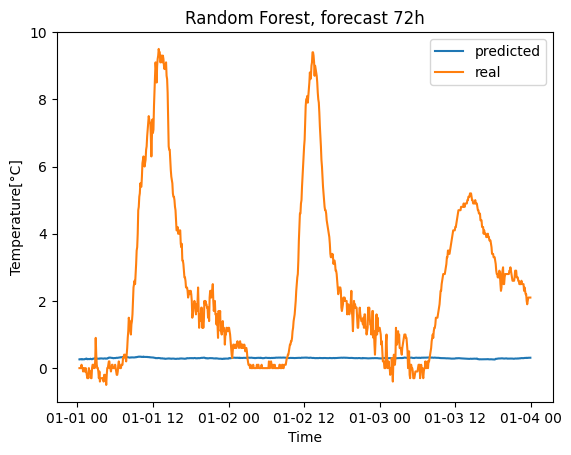

In [25]:
import pandas as pd 
import matplotlib.pyplot as plt
predictions_1440 = pd.read_csv("predictions_1440lags.csv")
predictions_1440 = predictions_1440[predictions_1440["ds"] >= '2023-01-01 00:20:00']
predictions_1440["ds"] = pd.to_datetime(predictions_1440["ds"])
plt.plot(predictions_1440["ds"], predictions_1440["RandomForestRegressor"], label="predicted")
plt.plot(test_processed_compare.index, test_processed_compare.values, label="real")
plt.xlabel("Time")
plt.ylabel("Temperature[°C]")
plt.title("Random Forest, forecast 72h")
plt.legend()

In [3]:
predictions_1440

,Unnamed: 0,unique_id,ds,RandomForestRegressor
0,0,AMBIENT_TEMPERATURE,2023-01-01 00:00:00,0.414
1,1,AMBIENT_TEMPERATURE,2023-01-01 00:05:00,0.337
2,2,AMBIENT_TEMPERATURE,2023-01-01 00:10:00,0.288
3,3,AMBIENT_TEMPERATURE,2023-01-01 00:15:00,0.270
4,4,AMBIENT_TEMPERATURE,2023-01-01 00:20:00,0.261
...,...,...,...,...
859,859,AMBIENT_TEMPERATURE,2023-01-03 23:35:00,0.308
860,860,AMBIENT_TEMPERATURE,2023-01-03 23:40:00,0.308
861,861,AMBIENT_TEMPERATURE,2023-01-03 23:45:00,0.308
862,862,AMBIENT_TEMPERATURE,2023-01-03 23:50:00,0.308


In [18]:
models = [RandomForestRegressor(random_state=123)]
model = MLForecast(models=models,
                    freq='5T',
                    lags=[1, 12 * 24, 7 * 12 * 24],
                    date_features=['dayofweek', 'month'],
                    target_transforms=[Differences([7 * 12 * 24])],
                    num_threads=2)
prepared_df = model.preprocess(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
prepared_df

,ds,y,unique_id,lag1,lag288,lag2016,dayofweek,month
4032,2020-10-27 11:55:00,6.7,AMBIENT_TEMPERATURE,6.9,6.0,-1.2,1,10
4033,2020-10-27 12:00:00,6.5,AMBIENT_TEMPERATURE,6.7,5.6,-1.2,1,10
4034,2020-10-27 12:05:00,5.8,AMBIENT_TEMPERATURE,6.5,5.6,-1.0,1,10
4035,2020-10-27 12:10:00,4.8,AMBIENT_TEMPERATURE,5.8,5.7,-1.0,1,10
4036,2020-10-27 12:15:00,4.2,AMBIENT_TEMPERATURE,4.8,5.6,-0.9,1,10
...,...,...,...,...,...,...,...,...
228492,2022-12-31 23:35:00,0.4,AMBIENT_TEMPERATURE,0.6,-0.3,1.6,5,12
228493,2022-12-31 23:40:00,0.7,AMBIENT_TEMPERATURE,0.4,-0.3,1.7,5,12
228494,2022-12-31 23:45:00,0.5,AMBIENT_TEMPERATURE,0.7,-0.5,1.7,5,12
228495,2022-12-31 23:50:00,0.3,AMBIENT_TEMPERATURE,0.5,-0.5,1.7,5,12


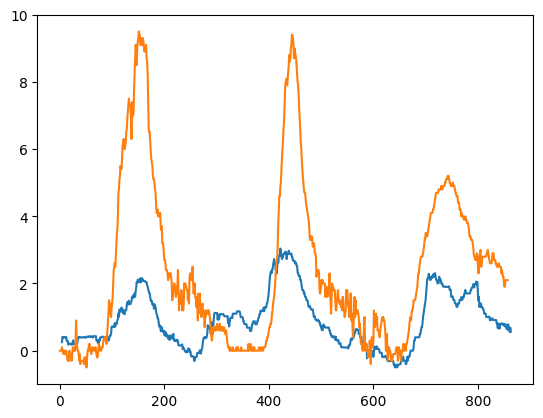

In [38]:
predictions_weekly_seasonality = pd.read_csv("predictions_weekly_seasonality.csv")
predictions_weekly_seasonality = predictions_weekly_seasonality[predictions_weekly_seasonality["ds"]>= '2023-01-01 00:20:00']
plt.plot(predictions_weekly_seasonality["RandomForestRegressor"])
plt.plot(test_processed_compare.values)


In [33]:
predictions_weekly_seasonality

,unique_id,ds,RandomForestRegressor
0,AMBIENT_TEMPERATURE,2023-01-01 00:00:00,0.405067
1,AMBIENT_TEMPERATURE,2023-01-01 00:05:00,0.383067
2,AMBIENT_TEMPERATURE,2023-01-01 00:10:00,0.383067
3,AMBIENT_TEMPERATURE,2023-01-01 00:15:00,0.310733
4,AMBIENT_TEMPERATURE,2023-01-01 00:20:00,0.254733
...,...,...,...
859,AMBIENT_TEMPERATURE,2023-01-03 23:35:00,0.662750
860,AMBIENT_TEMPERATURE,2023-01-03 23:40:00,0.684133
861,AMBIENT_TEMPERATURE,2023-01-03 23:45:00,0.560750
862,AMBIENT_TEMPERATURE,2023-01-03 23:50:00,0.684133


In [5]:
from gluonts.time_feature import time_features_from_frequency_str, get_lags_for_frequency, get_seasonality
papa = time_features_from_frequency_str("5min")
print(papa)

[<function minute_of_hour at 0x7fa86759ba60>, <function hour_of_day at 0x7fa86759bca0>, <function day_of_week at 0x7fa86759bdc0>, <function day_of_month at 0x7fa86759bee0>, <function day_of_year at 0x7fa867224040>]


In [6]:
lags_from_frequency = get_lags_for_frequency("5min")
print(lags_from_frequency)

[1, 2, 3, 4, 5, 6, 7, 10, 11, 12, 13, 14, 22, 23, 24, 25, 26, 34, 35, 36, 37, 38, 287, 288, 289, 575, 576, 577, 863, 864, 865, 1151, 1152, 1153]


In [7]:
seasonality = get_seasonality("5min")
seasonality

288

In [40]:
models = [RandomForestRegressor(random_state=123)]
model = MLForecast(models=models,
                    freq='5T',
                    lags=lags_from_frequency,
                    date_features=['minute', 'hour', 'dayofweek', 'day', 'dayofyear'],
                    target_transforms=[Differences([seasonality])],
                    num_threads=6)
df_prepared = model.preprocess(dataset_train, id_col='unique_id', time_col='ds', target_col='y', static_features=[])
df_prepared

,ds,y,unique_id,lag1,lag2,lag3,lag4,lag5,lag6,lag7,...,lag864,lag865,lag1151,lag1152,lag1153,minute,hour,dayofweek,day,dayofyear
1441,2020-10-18 10:35:00,0.2,AMBIENT_TEMPERATURE,0.0,-0.1,-0.2,-0.3,-0.3,-0.4,-0.2,...,-4.7,-5.1,3.2,3.0,3.5,35,10,6,18,292
1442,2020-10-18 10:40:00,0.2,AMBIENT_TEMPERATURE,0.2,0.0,-0.1,-0.2,-0.3,-0.3,-0.4,...,-4.7,-4.7,3.2,3.2,3.0,40,10,6,18,292
1443,2020-10-18 10:45:00,0.5,AMBIENT_TEMPERATURE,0.2,0.2,0.0,-0.1,-0.2,-0.3,-0.3,...,-4.9,-4.7,3.2,3.2,3.2,45,10,6,18,292
1444,2020-10-18 10:50:00,0.6,AMBIENT_TEMPERATURE,0.5,0.2,0.2,0.0,-0.1,-0.2,-0.3,...,-5.0,-4.9,3.3,3.2,3.2,50,10,6,18,292
1445,2020-10-18 10:55:00,0.7,AMBIENT_TEMPERATURE,0.6,0.5,0.2,0.2,0.0,-0.1,-0.2,...,-5.3,-5.0,3.2,3.3,3.2,55,10,6,18,292
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228492,2022-12-31 23:35:00,0.8,AMBIENT_TEMPERATURE,1.0,0.9,0.7,0.8,0.7,0.4,0.5,...,-0.3,-0.3,0.3,0.3,0.3,35,23,5,31,365
228493,2022-12-31 23:40:00,1.0,AMBIENT_TEMPERATURE,0.8,1.0,0.9,0.7,0.8,0.7,0.4,...,-0.2,-0.3,0.3,0.3,0.3,40,23,5,31,365
228494,2022-12-31 23:45:00,0.8,AMBIENT_TEMPERATURE,1.0,0.8,1.0,0.9,0.7,0.8,0.7,...,-0.3,-0.2,0.3,0.3,0.3,45,23,5,31,365
228495,2022-12-31 23:50:00,0.6,AMBIENT_TEMPERATURE,0.8,1.0,0.8,1.0,0.9,0.7,0.8,...,-0.2,-0.3,0.4,0.3,0.3,50,23,5,31,365


In [56]:
max(df_prepared["lag1153"])

21.1

In [11]:
import numpy as np

In [10]:
test_processed_regular = test_processed_compare.asfreq("5T")
ind = np.where(test_processed_regular.isna())[0]
ind

array([491, 492])

In [11]:
papa = test_processed_regular.iloc[ind].index

In [12]:
papa

DatetimeIndex(['2023-01-02 17:15:00', '2023-01-02 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='5T')

In [37]:
test_processed[test_processed.index == '2023-01-02 17:55:00']

,AMBIENT_TEMPERATURE
timestamp,
2023-01-02 17:55:00,1.8


In [29]:
test_processed_regular.iloc[491]

AMBIENT_TEMPERATURE   NaN
Name: 2023-01-02 17:15:00, dtype: float64

In [18]:
predictions_auto_features = pd.read_csv("predictions_auto_features.csv")
predictions_auto_features


,unique_id,ds,RandomForestRegressor
0,AMBIENT_TEMPERATURE,2023-01-01 00:00:00,0.352
1,AMBIENT_TEMPERATURE,2023-01-01 00:05:00,0.407
2,AMBIENT_TEMPERATURE,2023-01-01 00:10:00,0.289
3,AMBIENT_TEMPERATURE,2023-01-01 00:15:00,0.407
4,AMBIENT_TEMPERATURE,2023-01-01 00:20:00,0.387
...,...,...,...
859,AMBIENT_TEMPERATURE,2023-01-03 23:35:00,1.649
860,AMBIENT_TEMPERATURE,2023-01-03 23:40:00,1.830
861,AMBIENT_TEMPERATURE,2023-01-03 23:45:00,1.633
862,AMBIENT_TEMPERATURE,2023-01-03 23:50:00,1.421


Text(0, 0.5, 'Temperature[°C]')

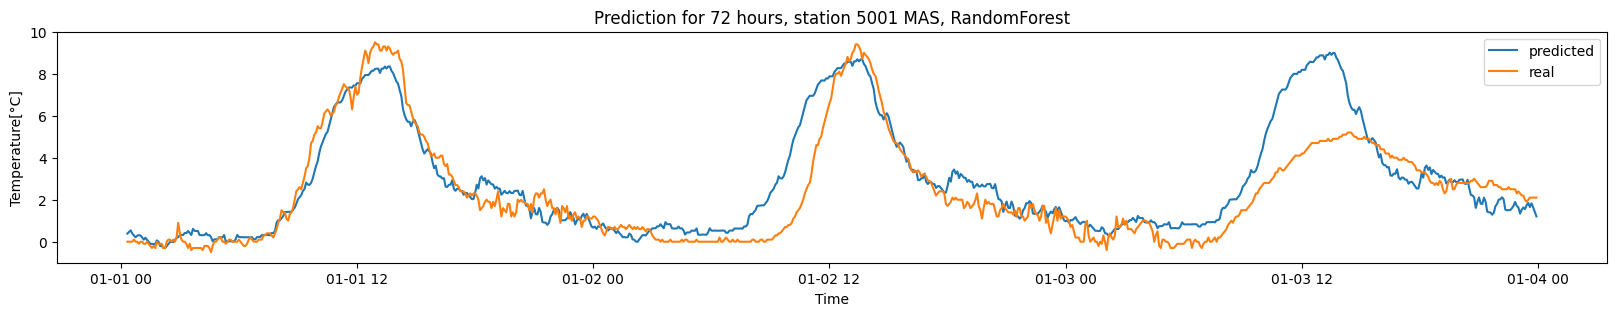

In [14]:
predictions_auto_features = pd.read_csv("predictions_auto_features.csv")
predictions_auto_features = predictions_auto_features[predictions_auto_features["ds"]>='2023-01-01 00:20:00']
predictions_auto_features["ds"] = pd.to_datetime(predictions_auto_features["ds"])
plt.figure(figsize=(20, 3))
plt.title("Prediction for 72 hours, station 5001 MAS, RandomForest")
plt.plot(predictions_auto_features["ds"], predictions_auto_features["RandomForestRegressor"], label="predicted")
plt.plot(test_processed_compare.index, test_processed_compare.values, label="real")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature[°C]")

In [44]:
# remove the indices in predictions that are missing in real test data
ind_1 = predictions_auto_features[predictions_auto_features["ds"] == '2023-01-02 17:15:00'].index
ind_2 = predictions_auto_features[predictions_auto_features["ds"] == '2023-01-02 17:20:00'].index
predictions_auto_features = predictions_auto_features.drop(ind_1)
predictions_auto_features = predictions_auto_features.drop(ind_2)


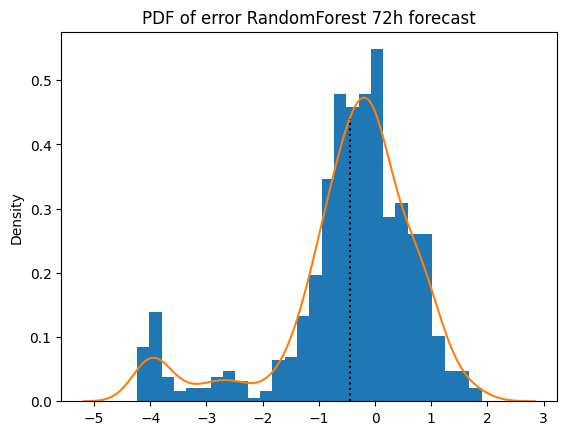

In [49]:
# pdf of error for RandomForest forecast 72h
error= test_processed_compare["AMBIENT_TEMPERATURE"].values - predictions_auto_features["RandomForestRegressor"].values
plt.hist(error, bins='auto', density=True)
plt.title("PDF of error RandomForest 72h forecast")
mean_error = error.mean()
ax = sns.kdeplot(data=error)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_error, xs, ys)
ax.vlines(mean_error, 0, height, color='black', ls=':')
plt.show()

In [5]:
from darts.timeseries import TimeSeries
from darts.utils.statistics import plot_acf, check_seasonality

train_darts = TimeSeries.from_values(train_processed["AMBIENT_TEMPERATURE"].values)

'''# check seasonality in train
for m in range(2, 288):
    is_seasonal, period = check_seasonality(train_darts, m=m, alpha=0.05)
    if is_seasonal:
        print("There is seasonality of order {}.".format(period))'''

'# check seasonality in train\nfor m in range(2, 288):\n    is_seasonal, period = check_seasonality(train_darts, m=m, alpha=0.05)\n    if is_seasonal:\n        print("There is seasonality of order {}.".format(period))'

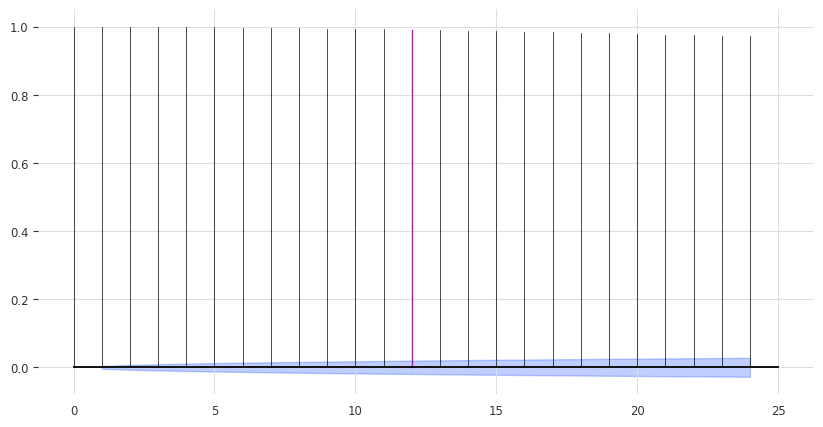

In [6]:
from darts.utils.statistics import plot_acf, check_seasonality

plot_acf(train_darts, m=12, alpha=0.05)

Text(0, 0.5, 'Temperature[°C]')

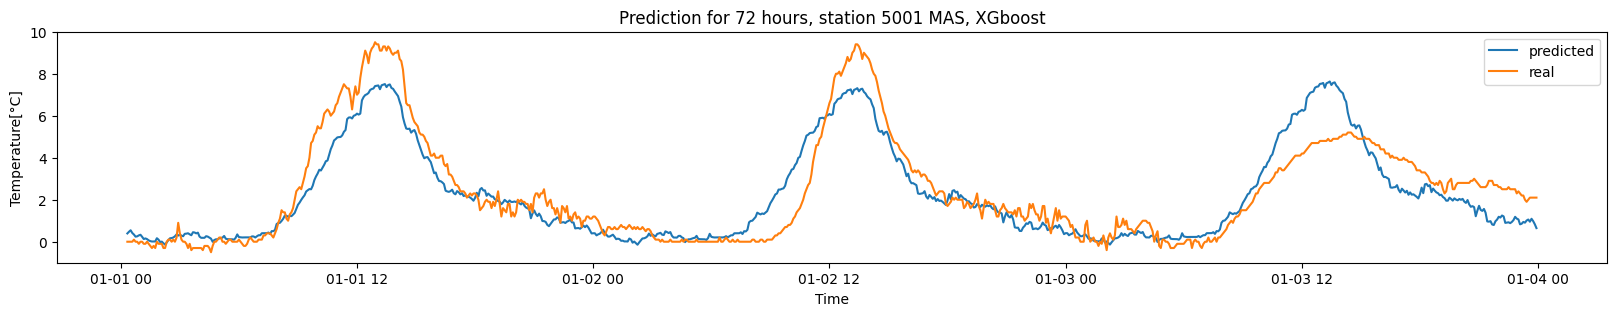

In [14]:
predictions_xgb = pd.read_csv(r"predictions_auto_features_xgb.csv")
predictions_xgb = predictions_xgb[predictions_xgb["ds"]>='2023-01-01 00:20:00']
predictions_xgb["ds"] = pd.to_datetime(predictions_xgb["ds"])
plt.figure(figsize=(20, 3))
plt.title("Prediction for 72 hours, station 5001 MAS, XGboost")
plt.plot(predictions_xgb["ds"], predictions_xgb["XGBRegressor"], label="predicted")
plt.plot(test_processed_compare.index, test_processed_compare.values, label="real")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature[°C]")


In [28]:
predictions_xgb["ds"].iloc[-1]

Timestamp('2023-01-03 23:55:00')

In [21]:
predictions_xgb_ds = predictions_xgb.set_index("ds")
olala = predictions_xgb_ds.loc[papa.values].index

In [22]:
predictions_xgb_ds.drop(olala)

,unique_id,XGBRegressor
ds,,
2023-01-01 00:20:00,AMBIENT_TEMPERATURE,0.394840
2023-01-01 00:25:00,AMBIENT_TEMPERATURE,0.474862
2023-01-01 00:30:00,AMBIENT_TEMPERATURE,0.545577
2023-01-01 00:35:00,AMBIENT_TEMPERATURE,0.415892
2023-01-01 00:40:00,AMBIENT_TEMPERATURE,0.342110
...,...,...
2023-01-03 23:35:00,AMBIENT_TEMPERATURE,0.953815
2023-01-03 23:40:00,AMBIENT_TEMPERATURE,1.092004
2023-01-03 23:45:00,AMBIENT_TEMPERATURE,0.980698


In [31]:
predictions["ds"].iloc[-1]

Timestamp('2023-01-03 23:55:00')

In [38]:
predictions = pd.read_csv(r'/home/iva/Desktop/operato-meteo-1/predictions_auto_features_xgb.csv')
predictions = predictions[predictions["ds"] >= '2023-01-01 00:20:00']
predictions["ds"] = pd.to_datetime(predictions["ds"])
test_processed_compare = test_processed[test_processed.index <= predictions["ds"].iloc[-1]]
test_processed_regular = test_processed_compare.asfreq("5T")
ind = np.where(test_processed_regular.isna())[0]
timestamps = test_processed_regular.iloc[ind].index
predictions_ds = predictions.set_index("ds")
predictions_ds
predictions_ds = predictions_ds.drop(predictions_ds.loc[timestamps.values].index)
predictions_ds

,unique_id,XGBRegressor
ds,,
2023-01-01 00:20:00,AMBIENT_TEMPERATURE,0.394840
2023-01-01 00:25:00,AMBIENT_TEMPERATURE,0.474862
2023-01-01 00:30:00,AMBIENT_TEMPERATURE,0.545577
2023-01-01 00:35:00,AMBIENT_TEMPERATURE,0.415892
2023-01-01 00:40:00,AMBIENT_TEMPERATURE,0.342110
...,...,...
2023-01-03 23:35:00,AMBIENT_TEMPERATURE,0.953815
2023-01-03 23:40:00,AMBIENT_TEMPERATURE,1.092004
2023-01-03 23:45:00,AMBIENT_TEMPERATURE,0.980698


In [ ]:
predictions_xgb_ds

In [87]:
predictions_xgb

,unique_id,ds,XGBRegressor
4,AMBIENT_TEMPERATURE,2023-01-01 00:20:00,0.394840
5,AMBIENT_TEMPERATURE,2023-01-01 00:25:00,0.474862
6,AMBIENT_TEMPERATURE,2023-01-01 00:30:00,0.545577
7,AMBIENT_TEMPERATURE,2023-01-01 00:35:00,0.415892
8,AMBIENT_TEMPERATURE,2023-01-01 00:40:00,0.342110
...,...,...,...
859,AMBIENT_TEMPERATURE,2023-01-03 23:35:00,0.953815
860,AMBIENT_TEMPERATURE,2023-01-03 23:40:00,1.092004
861,AMBIENT_TEMPERATURE,2023-01-03 23:45:00,0.980698
862,AMBIENT_TEMPERATURE,2023-01-03 23:50:00,0.832116


In [101]:
papa[0]

Timestamp('2023-01-02 17:15:00', freq='5T')

In [103]:
predictions_xgb[predictions_xgb["ds"] == papa[0]]

,unique_id,ds,XGBRegressor
495,AMBIENT_TEMPERATURE,2023-01-02 17:15:00,2.043244


In [96]:
predictions_xgb["ds"].loc[papa.values]

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictions_xgb["ds"].loc[papa.values]                                                       │
│   2                                                                                              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1073 in  │
│ __getitem__                                                                                      │
│                                                                                                  │
│   1070 │   │   │   axis = self.axis or 0                                                         │
│   1071 │   │   │                                                                                 │
│   1072 │   │   │   maybe_callable = com.apply_if_callable(key, self.obj)                         │
│ ❱ 1073 │   │   │   return self._getitem_axis(maybe_callable, axis=axis)                          │
│   1074 │                                                                                         │
│   1075 │   def _is_scalar_access(self, key: tuple):                                              │
│   1076 │   │   raise NotImplementedError()                                                       │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1301 in  │
│ _getitem_axis                                                                                    │
│                                                                                                  │
│   1298 │   │   │   │   if hasattr(key, "ndim") and key.ndim > 1:                                 │
│   1299 │   │   │   │   │   raise ValueError("Cannot index with multidimensional key")            │
│   1300 │   │   │   │                                                                             │
│ ❱ 1301 │   │   │   │   return self._getitem_iterable(key, axis=axis)                             │
│   1302 │   │   │                                                                                 │
│   1303 │   │   │   # nested tuple slicing                                                        │
│   1304 │   │   │   if is_nested_tuple(key, labels):                                              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/indexing.py:1239 in  │
│ _getitem_iterable                                                                                │
│                                                                                                  │
│   1236 │   │   self._validate_key(key, axis)                                                     │
│   1237 │   │                                                                                     │
│   1238 │   │   # A collection of keys                                                            │
│ ❱ 1239 │   │   keyarr, indexer = self._get_listlike_indexer(key, axis)                           │
│   1240 │   │   return self.obj._reindex_with_indexers(                                           │
│   1241 │   │   │   {axis: [keyarr, indexer]}, copy=True, allow_dups=True                         │
│   1242 │   │   )                                                                                 │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-pack

In [92]:
papa

DatetimeIndex(['2023-01-02 17:15:00', '2023-01-02 17:20:00'], dtype='datetime64[ns]', name='timestamp', freq='5T')

In [91]:
predictions_xgb[predictions_xgb["ds"] == papa].index

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictions_xgb[predictions_xgb["ds"] == papa].index                                         │
│   2                                                                                              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/ops/common.py:72 in  │
│ new_method                                                                                       │
│                                                                                                  │
│    69 │   │                                                                                      │
│    70 │   │   other = item_from_zerodim(other)                                                   │
│    71 │   │                                                                                      │
│ ❱  72 │   │   return method(self, other)                                                         │
│    73 │                                                                                          │
│    74 │   return new_method                                                                      │
│    75                                                                                            │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/arraylike.py:42 in   │
│ __eq__                                                                                           │
│                                                                                                  │
│    39 │                                                                                          │
│    40 │   @unpack_zerodim_and_defer("__eq__")                                                    │
│    41 │   def __eq__(self, other):                                                               │
│ ❱  42 │   │   return self._cmp_method(other, operator.eq)                                        │
│    43 │                                                                                          │
│    44 │   @unpack_zerodim_and_defer("__ne__")                                                    │
│    45 │   def __ne__(self, other):                                                               │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/series.py:6243 in    │
│ _cmp_method                                                                                      │
│                                                                                                  │
│   6240 │   │   rvalues = extract_array(other, extract_numpy=True, extract_range=True)            │
│   6241 │   │                                                                                     │
│   6242 │   │   with np.errstate(all="ignore"):                                                   │
│ ❱ 6243 │   │   │   res_values = ops.comparison_op(lvalues, rvalues, op)                          │
│   6244 │   │                                                                                     │
│   6245 │   │   return self._construct_result(res_values, name=res_name)                          │
│   6246                                                                                           │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-pack

In [89]:
predictions_xgb.drop(predictions_xgb[predictions_xgb["ds"]])

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:1                                                                                    │
│                                                                                                  │
│ ❱ 1 predictions_xgb.drop(labels=papa.values, axis=1)                                             │
│   2                                                                                              │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:331   │
│ in wrapper                                                                                       │
│                                                                                                  │
│   328 │   │   │   │   │   FutureWarning,                                                         │
│   329 │   │   │   │   │   stacklevel=find_stack_level(),                                         │
│   330 │   │   │   │   )                                                                          │
│ ❱ 331 │   │   │   return func(*args, **kwargs)                                                   │
│   332 │   │                                                                                      │
│   333 │   │   # error: "Callable[[VarArg(Any), KwArg(Any)], Any]" has no                         │
│   334 │   │   # attribute "__signature__"                                                        │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/core/frame.py:5399 in     │
│ drop                                                                                             │
│                                                                                                  │
│    5396 │   │   falcon  speed   320.0   250.0                                                    │
│    5397 │   │   │   │   weight  1.0     0.8                                                      │
│    5398 │   │   """                                                                              │
│ ❱  5399 │   │   return super().drop(                                                             │
│    5400 │   │   │   labels=labels,                                                               │
│    5401 │   │   │   axis=axis,                                                                   │
│    5402 │   │   │   index=index,                                                                 │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-packages/pandas/util/_decorators.py:331   │
│ in wrapper                                                                                       │
│                                                                                                  │
│   328 │   │   │   │   │   FutureWarning,                                                         │
│   329 │   │   │   │   │   stacklevel=find_stack_level(),                                         │
│   330 │   │   │   │   )                                                                          │
│ ❱ 331 │   │   │   return func(*args, **kwargs)                                                   │
│   332 │   │                                                                                      │
│   333 │   │   # error: "Callable[[VarArg(Any), KwArg(Any)], Any]" has no                         │
│   334 │   │   # attribute "__signature__"                                                        │
│                                                                                                  │
│ /home/iva/anaconda3/envs/Python_3.9/lib/python3.9/site-pack

In [19]:
# remove the indices in predictions that are missing in real test data
ind_1 = predictions_xgb[predictions_xgb["ds"] == '2023-01-02 17:15:00'].index
ind_2 = predictions_xgb[predictions_xgb["ds"] == '2023-01-02 17:20:00'].index
predictions_xgb = predictions_xgb.drop(ind_1)
predictions_xgb = predictions_xgb.drop(ind_2)

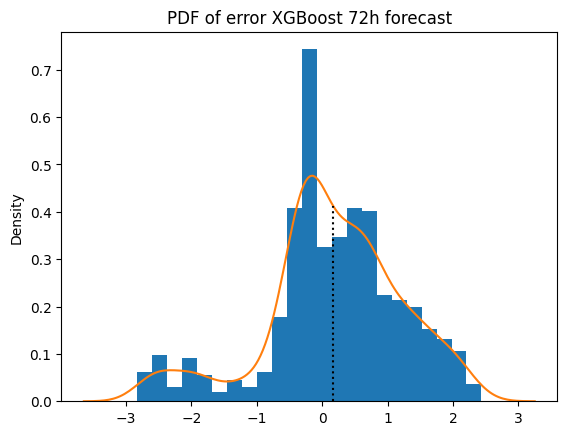

In [24]:
# pdf of error for XGBoost forecast 72h
error= test_processed_compare["AMBIENT_TEMPERATURE"].values - predictions_xgb["XGBRegressor"].values
plt.hist(error, bins='auto', density=True)
plt.title("PDF of error XGBoost 72h forecast")
mean_error = error.mean()
ax = sns.kdeplot(data=error)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_error, xs, ys)
ax.vlines(mean_error, 0, height, color='black', ls=':')
plt.show()

In [6]:
# converting to frequency one hour 
train_processed_one_hour = train_processed.asfreq("1H")#.dropna()
test_processed_one_hour = test_processed.asfreq("1H").dropna()

In [64]:
idx = np.where(train_processed_one_hour.isnull())[0]
train_processed_one_hour.iloc[idx] = 50

In [18]:
from missing_timestamps import missing_data

missing_timestamps_train_one_hour, missing_values_filled_previous_train_hour = missing_data(train_processed_one_hour)
missing_timestamps_test_one_hour, missing_values_filled_previous_test_hour = missing_data(test_processed_one_hour)




In [16]:
from gluonts.time_feature import time_features_from_frequency_str, get_lags_for_frequency, get_seasonality
# to do za 1h
papa = time_features_from_frequency_str("1H")
lags_from_frequency = get_lags_for_frequency("1H")
seasonality = get_seasonality("1H")


In [4]:
print(papa)

[<function hour_of_day at 0x7f5b02aa1af0>, <function day_of_week at 0x7f5b02aa1c10>, <function day_of_month at 0x7f5b02aa1d30>, <function day_of_year at 0x7f5b02aa1e50>]


In [5]:
print(lags_from_frequency)

[1, 2, 3, 4, 5, 6, 7, 23, 24, 25, 47, 48, 49, 71, 72, 73, 95, 96, 97, 119, 120, 121, 143, 144, 145, 167, 168, 169, 335, 336, 337, 503, 504, 505, 671, 672, 673, 719, 720, 721]


In [17]:
print(seasonality)

24


In [5]:
int_indices = [t for t in range(1, len(test_processed_one_hour[0:4])+1)]


In [104]:
dataset_test = pd.DataFrame()
dataset_test["ds"] = test_processed_one_hour[0:34].index
dataset_test["y"] = test_processed_one_hour["AMBIENT_TEMPERATURE"][0:34].values
dataset_test["unique_id"] = "AMBIENT_TEMPERATURE"

In [56]:
dataset_train = pd.DataFrame()
dataset_train["ds"] = train_processed_one_hour.index
dataset_train["y"] = train_processed_one_hour["AMBIENT_TEMPERATURE"].values
dataset_train["unique_id"] = "AMBIENT_TEMPERATURE"

In [53]:
test_compare_one_hour = test_processed_one_hour[test_processed_one_hour.index >= '2023-01-31 06:20:00']

Text(0, 0.5, 'Temperature[°C]')

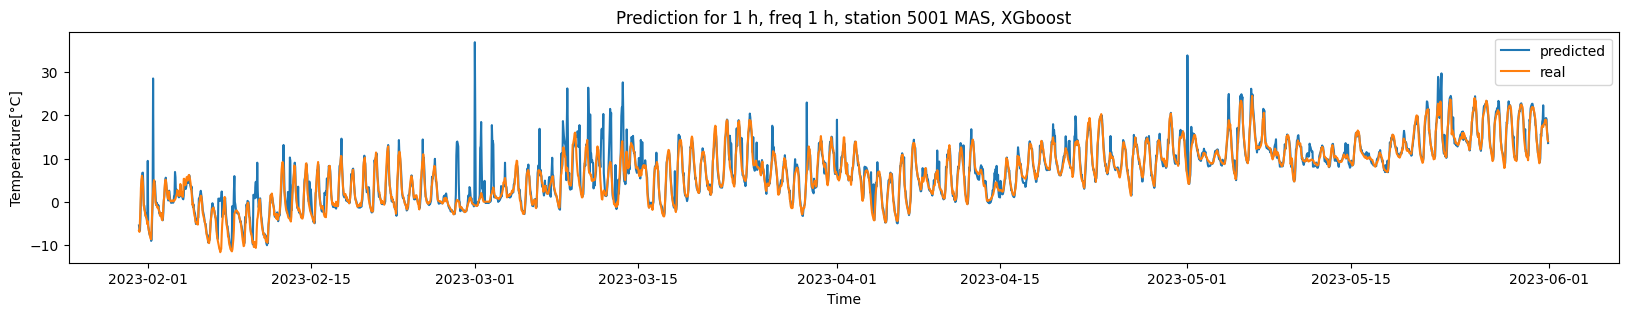

In [58]:
# forecast 1 h, freq 1 h, without removed seasonality
predictions_all = pd.read_csv("predictions_xgb_freq_1h_forecast_1h_whole_test.csv")
predictions_all["ds"] = pd.to_datetime(predictions_all["ds"])


plt.figure(figsize=(20, 3))
plt.title("Prediction for 1 h, freq 1 h, station 5001 MAS, XGboost")
plt.plot(predictions_all["ds"], predictions_all["XGBRegressor"], label="predicted")
plt.plot(test_compare_one_hour.index, test_compare_one_hour.values, label="real")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature[°C]")

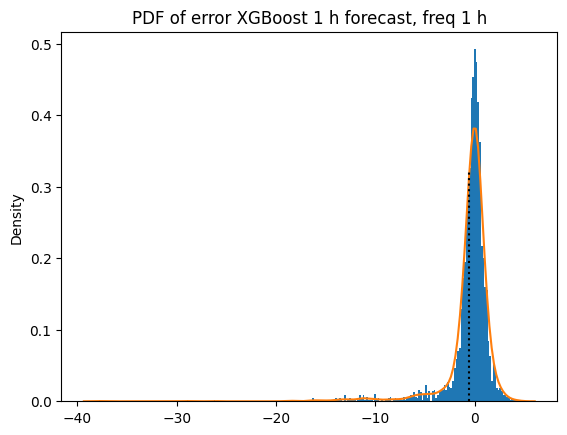

In [60]:
# pdf of error for forecast 1 h, freq 1 h
error= test_compare_one_hour["AMBIENT_TEMPERATURE"].values - predictions_all["XGBRegressor"].values
plt.hist(error, bins='auto', density=True)
plt.title("PDF of error XGBoost 1 h forecast, freq 1 h")
mean_error = error.mean()
ax = sns.kdeplot(data=error)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_error, xs, ys)
ax.vlines(mean_error, 0, height, color='black', ls=':')
plt.show()

Text(0, 0.5, 'Temperature[°C]')

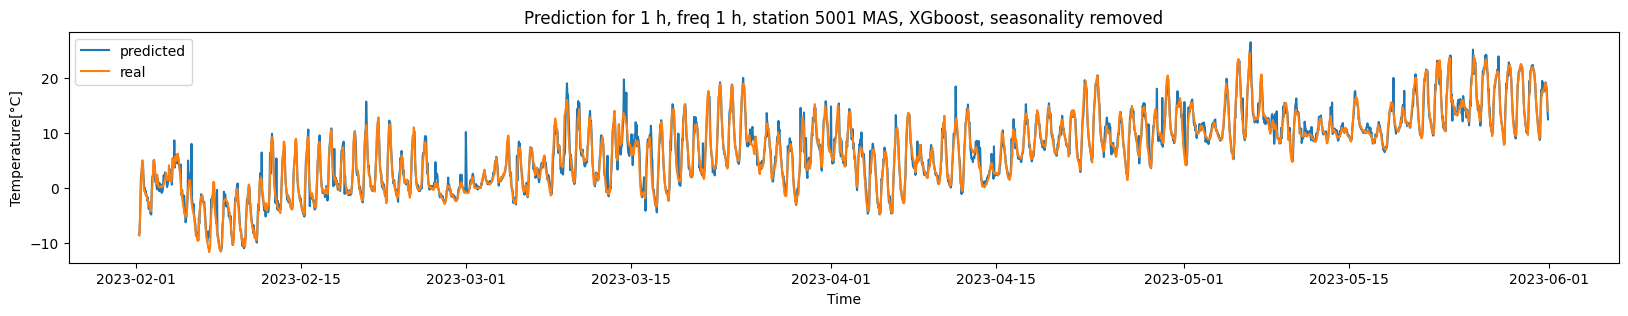

In [132]:
# forecast 1 h, freq 1 h
predictions_removed_seasonality = pd.read_csv('predictions_xgb_freq_1h_forecast_1h_whole_test_removed_seasonality.csv')
predictions_removed_seasonality["ds"] = pd.to_datetime(predictions_removed_seasonality["ds"])
test_processed_compare_removed_seasonality = test_processed_one_hour[(test_processed_one_hour.index >= '2023-02-01 06:20:00') & (test_processed_one_hour.index <= '2023-05-31 21:20:00')]

plt.figure(figsize=(20, 3))
plt.title("Prediction for 1 h, freq 1 h, station 5001 MAS, XGboost, seasonality removed")
plt.plot(predictions_removed_seasonality["ds"], predictions_removed_seasonality["XGBRegressor"], label="predicted")
plt.plot(test_processed_compare_removed_seasonality.index, test_processed_compare_removed_seasonality.values, label="real")
#plt.xlim(pd.to_datetime('2023-02-01'), pd.to_datetime('2023-02-02'))
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature[°C]")

In [130]:
train_processed_one_hour[-745:]

,AMBIENT_TEMPERATURE
timestamp,
2022-11-30 23:20:00,0.4
2022-12-01 00:20:00,50.0
2022-12-01 01:20:00,0.3
2022-12-01 02:20:00,0.5
2022-12-01 03:20:00,0.3
...,...
2022-12-31 19:20:00,1.9
2022-12-31 20:20:00,1.9
2022-12-31 21:20:00,1.1


In [139]:
train_processed_one_hour_compare = train_processed.asfreq("1H").dropna()

In [144]:
train_processed_one_hour[train_processed_one_hour["AMBIENT_TEMPERATURE"]==50]

,AMBIENT_TEMPERATURE
timestamp,
2020-10-20 23:20:00,50.0
2020-10-21 00:20:00,50.0
2020-10-23 22:20:00,50.0
2020-11-13 18:20:00,50.0
2020-11-18 01:20:00,50.0
...,...
2022-12-01 00:20:00,50.0
2022-12-07 00:20:00,50.0
2022-12-07 01:20:00,50.0


In [146]:
train_processed_one_hour_compare[-745:]

,AMBIENT_TEMPERATURE
timestamp,
2022-11-30 18:20:00,1.0
2022-11-30 19:20:00,0.8
2022-11-30 20:20:00,0.7
2022-11-30 21:20:00,0.6
2022-11-30 22:20:00,0.4
...,...
2022-12-31 19:20:00,1.9
2022-12-31 20:20:00,1.9
2022-12-31 21:20:00,1.1


In [145]:
train_processed_one_hour_compare[train_processed_one_hour_compare.index == '2020-10-20 23:20:00']

,AMBIENT_TEMPERATURE
timestamp,


In [141]:
just_try = pd.concat([train_processed_one_hour_compare[-745:], test_processed_one_hour])
just_try[:745]

,AMBIENT_TEMPERATURE
timestamp,
2022-11-30 18:20:00,1.0
2022-11-30 19:20:00,0.8
2022-11-30 20:20:00,0.7
2022-11-30 21:20:00,0.6
2022-11-30 22:20:00,0.4
...,...
2022-12-31 19:20:00,1.9
2022-12-31 20:20:00,1.9
2022-12-31 21:20:00,1.1


In [133]:
dataset_test = pd.DataFrame()
dataset_test["ds"] = test_processed_one_hour.index
dataset_test["y"] = test_processed_one_hour["AMBIENT_TEMPERATURE"].values
dataset_test["unique_id"] = "AMBIENT_TEMPERATURE"

In [134]:
dataset_test

,ds,y,unique_id
0,2023-01-01 00:20:00,0.0,AMBIENT_TEMPERATURE
1,2023-01-01 01:20:00,-0.0,AMBIENT_TEMPERATURE
2,2023-01-01 02:20:00,0.0,AMBIENT_TEMPERATURE
3,2023-01-01 03:20:00,-0.1,AMBIENT_TEMPERATURE
4,2023-01-01 04:20:00,-0.2,AMBIENT_TEMPERATURE
...,...,...,...
3581,2023-05-31 17:20:00,18.9,AMBIENT_TEMPERATURE
3582,2023-05-31 18:20:00,17.3,AMBIENT_TEMPERATURE
3583,2023-05-31 19:20:00,16.0,AMBIENT_TEMPERATURE
3584,2023-05-31 20:20:00,14.4,AMBIENT_TEMPERATURE


In [128]:
test_processed_one_hour

,AMBIENT_TEMPERATURE
timestamp,
2023-01-01 00:20:00,0.0
2023-01-01 01:20:00,-0.0
2023-01-01 02:20:00,0.0
2023-01-01 03:20:00,-0.1
2023-01-01 04:20:00,-0.2
...,...
2023-05-31 17:20:00,18.9
2023-05-31 18:20:00,17.3
2023-05-31 19:20:00,16.0


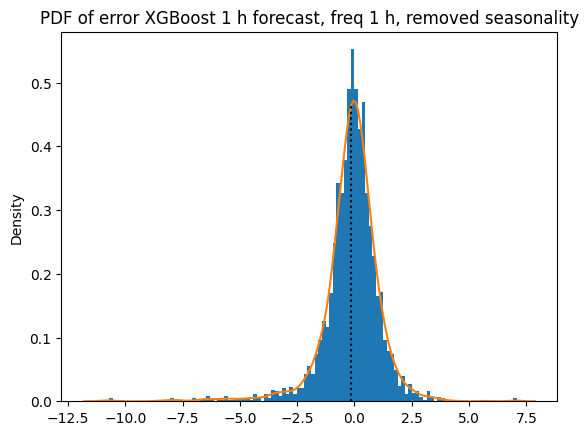

In [120]:
# pdf of error for forecast 1 h, freq 1 h, removed seasonality
error= test_processed_compare_removed_seasonality["AMBIENT_TEMPERATURE"].values - predictions_removed_seasonality["XGBRegressor"].values
plt.hist(error, bins='auto', density=True)
plt.title("PDF of error XGBoost 1 h forecast, freq 1 h, removed seasonality")
mean_error = error.mean()
ax = sns.kdeplot(data=error)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_error, xs, ys)
ax.vlines(mean_error, 0, height, color='black', ls=':')
plt.show()

In [125]:
test_processed_compare_removed_seasonality

,AMBIENT_TEMPERATURE
timestamp,
2023-02-01 06:20:00,-8.6
2023-02-01 07:20:00,-8.7
2023-02-01 08:20:00,-5.6
2023-02-01 09:20:00,-2.1
2023-02-01 10:20:00,0.6
...,...
2023-05-31 17:20:00,18.9
2023-05-31 18:20:00,17.3
2023-05-31 19:20:00,16.0


In [126]:
predictions_removed_seasonality

,Unnamed: 0,unique_id,ds,XGBRegressor
0,0,AMBIENT_TEMPERATURE,2023-02-01 06:20:00,-8.397199
1,0,AMBIENT_TEMPERATURE,2023-02-01 07:20:00,-8.200732
2,0,AMBIENT_TEMPERATURE,2023-02-01 08:20:00,-6.193061
3,0,AMBIENT_TEMPERATURE,2023-02-01 09:20:00,-2.581228
4,0,AMBIENT_TEMPERATURE,2023-02-01 10:20:00,2.047006
...,...,...,...,...
2836,0,AMBIENT_TEMPERATURE,2023-05-31 17:20:00,18.542480
2837,0,AMBIENT_TEMPERATURE,2023-05-31 18:20:00,18.203465
2838,0,AMBIENT_TEMPERATURE,2023-05-31 19:20:00,16.608568
2839,0,AMBIENT_TEMPERATURE,2023-05-31 20:20:00,13.817669


In [148]:
test_processed_one_hour

,AMBIENT_TEMPERATURE
timestamp,
2023-01-01 00:20:00,0.0
2023-01-01 01:20:00,-0.0
2023-01-01 02:20:00,0.0
2023-01-01 03:20:00,-0.1
2023-01-01 04:20:00,-0.2
...,...
2023-05-31 17:20:00,18.9
2023-05-31 18:20:00,17.3
2023-05-31 19:20:00,16.0


In [150]:
# first prediction for forecast 1h
prediction_1 = pd.read_csv("first_prediction_forecast_1h_freq_1h.csv")
prediction_1

,unique_id,ds,XGBRegressor
0,AMBIENT_TEMPERATURE,2023-01-01 00:20:00,29.084373


Text(0, 0.5, 'Temperature[°C]')

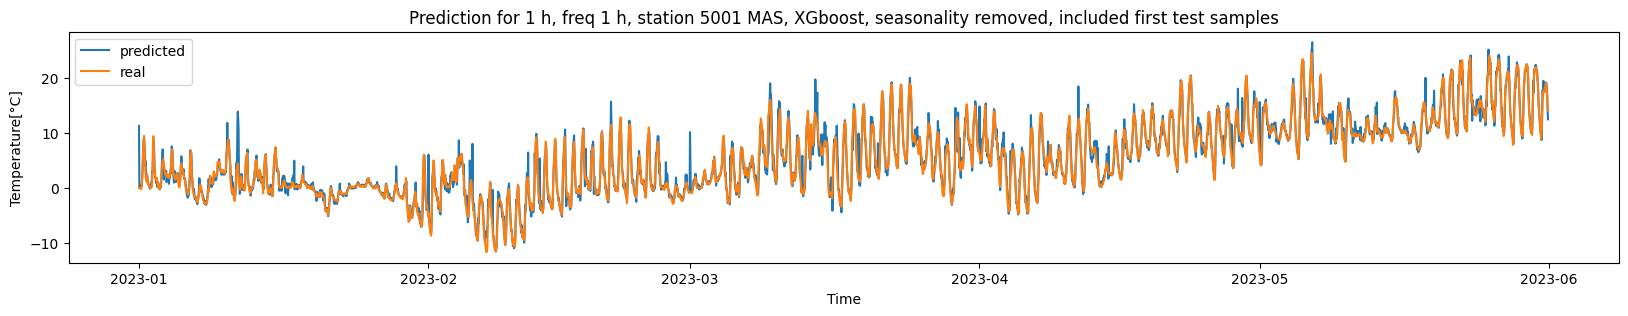

In [11]:
# whole test including the first samples in test
predictions_whole = pd.read_csv('predictions_xgb_freq_1h_forecast_1h_removed_seasonality_first_samples_test.csv')
predictions_whole["ds"] = pd.to_datetime(predictions_whole["ds"])


plt.figure(figsize=(20, 3))
plt.title("Prediction for 1 h, freq 1 h, station 5001 MAS, XGboost, seasonality removed, included first test samples")
plt.plot(predictions_whole["ds"], predictions_whole["XGBRegressor"], label="predicted")
plt.plot(test_processed_one_hour.index, test_processed_one_hour.values, label="real")
#plt.xlim(pd.to_datetime('2023-01-01'), pd.to_datetime('2023-01-04'))
plt.legend()
plt.xlabel("Time")
plt.ylabel("Temperature[°C]")


In [172]:
test_processed_one_hour

,AMBIENT_TEMPERATURE
timestamp,
2023-01-01 00:20:00,0.0
2023-01-01 01:20:00,-0.0
2023-01-01 02:20:00,0.0
2023-01-01 03:20:00,-0.1
2023-01-01 04:20:00,-0.2
...,...
2023-05-31 17:20:00,18.9
2023-05-31 18:20:00,17.3
2023-05-31 19:20:00,16.0


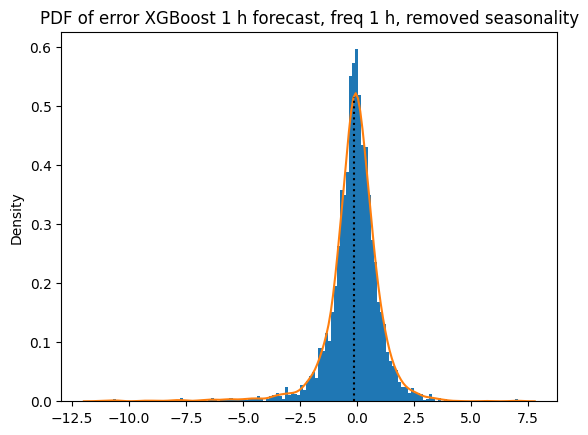

In [166]:
# pdf of error for forecast 1 h, freq 1 h, removed seasonality, whole test
error= test_processed_one_hour["AMBIENT_TEMPERATURE"].values - predictions_whole["XGBRegressor"].values
plt.hist(error, bins='auto', density=True)
plt.title("PDF of error XGBoost 1 h forecast, freq 1 h, removed seasonality")
mean_error = error.mean()
ax = sns.kdeplot(data=error)
kdeline = ax.lines[0]
xs = kdeline.get_xdata()
ys = kdeline.get_ydata()
height = np.interp(mean_error, xs, ys)
ax.vlines(mean_error, 0, height, color='black', ls=':')
plt.show()

In [154]:
train_processed_one_hour_compare = train_processed.asfreq("1H").dropna()
train_test = pd.concat([train_processed_one_hour_compare, test_processed_one_hour])

In [156]:
train_processed_one_hour_compare

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 11:20:00,8.9
2020-10-13 12:20:00,10.0
2020-10-13 13:20:00,10.7
2020-10-13 14:20:00,10.8
...,...
2022-12-31 19:20:00,1.9
2022-12-31 20:20:00,1.9
2022-12-31 21:20:00,1.1


In [161]:
train_test[:19059]

,AMBIENT_TEMPERATURE
timestamp,
2020-10-13 10:20:00,7.4
2020-10-13 11:20:00,8.9
2020-10-13 12:20:00,10.0
2020-10-13 13:20:00,10.7
2020-10-13 14:20:00,10.8
...,...
2022-12-31 19:20:00,1.9
2022-12-31 20:20:00,1.9
2022-12-31 21:20:00,1.1
